# Introduction
The dataset included in this project contains information about credit card transactions and their labels as either legitimate or fraudulent transactions. As the vast majority of transactions carried out are legitimate, this is a highly imbalanced dataset. Using different techniques such as undersampling, oversampling, and SMOTE, we will attempt to balance the data and train machine learning models to correctly predict whether a transaction is fraudulent or not.

## Dataset Contents
The dataset contains transactions made by credit cards in September 2013 by European cardholders over a period of two days. 


## Importing the Necessary Libraries
Here we'll begin by importing some of the libraries we'll use in the project.


In [183]:
## libraries for loading and exploring data
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

## splitting and balancing data
from sklearn.model_selection import train_test_split
from imblearn.under_sampling import RandomUnderSampler

## ML models
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

## metrics for evaluating models
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.metrics import average_precision_score, precision_recall_curve, auc

## misc
from collections import Counter

## Loading the Data
Next, we'll load the data, found in `creditcard.csv` and print the first few rows to see what we're working with.

In [2]:
df = pd.read_csv("creditcard.csv")
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


## Exploring the Data
Initial exploration of the data shows a few things. We have 31 columns:
- Time (in seconds, elapsed since first transaction in dataset)
- V1-V28 Primary components which have been transformed into numerical data. For reasons of confidentiality, the true labels of these features are unknown.
- Amount (how much was spent in that transaction)
- Class (0 for legitimate transaction, 1 for fraudulent. From this point on, 0 will be referred to as **legitimate** and 1 as **fraudulent**) 

## Visualizing the Data
As previously mentioned, this is a highly imbalanced dataset. The amount of legitimate transactions are significantly higher than those of fraudulent charges. 

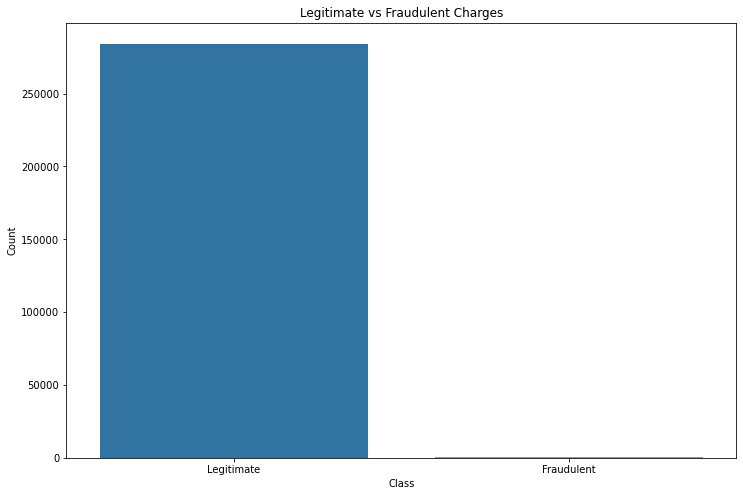

In [7]:
plt.figure(figsize=(12,8))
ax = plt.subplot()
sns.countplot(x='Class', data=df)
ax.set_xticklabels(['Legitimate', 'Fraudulent'])
plt.ylabel("Count")
plt.title("Legitimate vs Fraudulent Charges")
plt.show()

In [9]:
df['Class'].value_counts(normalize=True)

0    0.998273
1    0.001727
Name: Class, dtype: float64

The fraudulent class is barely visible on our graph, and it's clear why if we see the normalized value counts for this dataset. Legitimate charges compose 99.82% of the data in this dataset, while fraudulent charges make up only 0.17% of this dataset.

## Potential Problems
Up to this point, it's been made clear that this dataset is imbalanced, but what exactly does that mean and how does it affect a machine learning model? Let's train a model without altering the data in any way to see what happens. Let's split our data into a training set and testing set as it is, then train several machine learning models on it.

### Splitting the Data (Imbalanced)

In [ ]:
X, y = df.iloc[:, 1:-2].values, df.iloc[:, -1:].values
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=100)

### Logistic Regression (Imbalanced)

In [199]:
lr_imb = LogisticRegression()
lr_imb.fit(X_train, np.ravel(y_train))
lr_imb_predict = lr_imb.predict(X_test)
print(accuracy_score(y_test, lr_imb_predict))

0.9990449706468919


### Decision Tree Classifier (Imbalanced)

In [202]:
tree_imb = DecisionTreeClassifier()
tree_imb.fit(X_train, np.ravel(y_train))
tree_imb_predict = lr_imb.predict(X_test)
print(accuracy_score(y_test, tree_imb_predict))

0.9990449706468919


Amazing! Our models all have greater than 99% accuracy!

Machine learning models are most commonly scored by measuring accuracy. This is the formula used to measure accuracy:

<img src="accuracy.png" width="500" height="56" />

The problem with this method is that it overvalues correct predictions when the dataset is imbalanced. Consider assigning this same task to a person. After seeing maybe a hundred rows with no fraudulent charges, they may decide that the smart way to classify data is to simply guess "legitimate" every single time. At the end of the day, they may be wrong once or twice, but they'll be correct 99% of the time.

The solution to this is to either balance the data or more heavily penalize the ML model when it fails to detect a fraudulent case. In other words, find a way to give equal weight to both detections, so the model will not be incentivized to simply guess one class over and over. We can also evaluate our ML models using different metrics, such as precision, recall, or F1-score.

## Potential Solutions

### Measuring Using Precision-Recall Curve
As mentioned previously, we can either balance the data in some way, or we can try to measure our model on a different metric. One way to deal with this data imbalance using the model we've already trained is to calculate the **Area Under Precision-Recall Curve(AUPRC)**. The `auc()` function will let us calculate the area under the curve, while `precision_recall_curve()` will let us create the curve based on our predictions. 

Assuming the model scores highly using precision and recall, even though our data is imbalanced, we could say that it's accurate at predicting fraud.

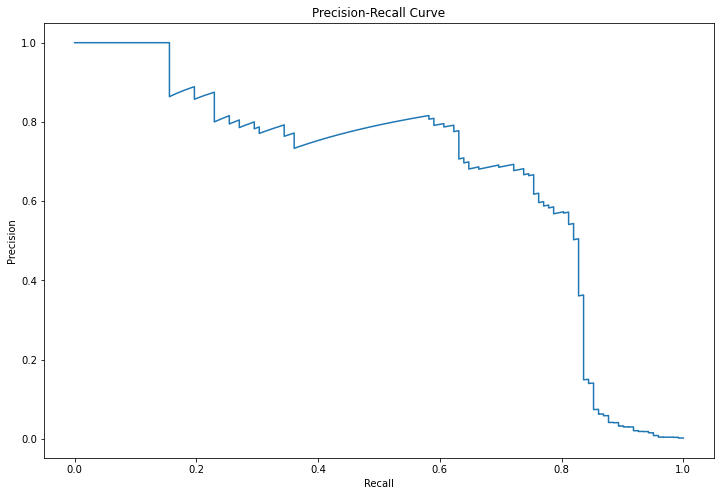

0.6707497818825712


In [200]:
lr_imb_probs = lr_test.predict_proba(X_test)[:, 1]
lr_imb_prec, lr_imb_recall, lr_imb_threshold = precision_recall_curve(y_test, lr_imb_probs)
plt.figure(figsize=(12,8))
plt.plot(lr_imb_recall, lr_imb_prec, label='Logistic Regression')
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.show()
print(auc(lr_imb_recall, lr_imb_prec))

### Analysis Using AUPRC
Unfortunately, the area under the curve was 0.67, which is not very good. The model, while better than a random classifier, makes enough mistakes that it shouldn't be trusted to predict fraud accurately. 

### Undersampling
Undersampling allows us to set the majority class equal to the minority class. That means if we have 400 rows that represent fraudulent data, instead of training our model on 20,000+ rows of legitimate transactions and only 400 rows of fraudulent transactions as we did above, we'll undersample our legitimate class to just include 400 rows.

In our particular example, we're using `RandomUnderSampler` to do this. Both our classes will now have 492 rows of data that we'll train our ML model on.

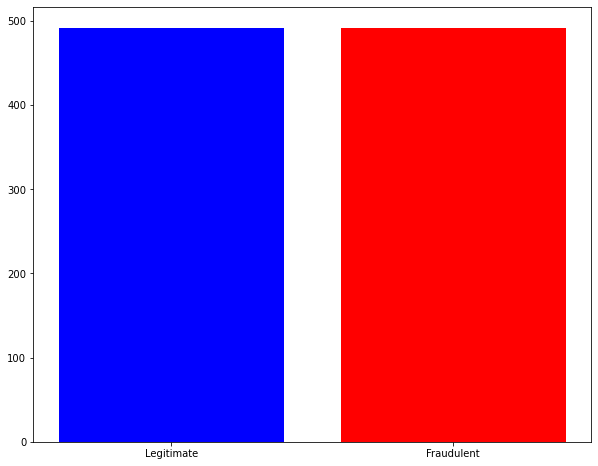

Counter({0: 492, 1: 492})


In [91]:
rus = RandomUnderSampler(random_state=1, replacement=True)
X_rus, y_rus = rus.fit_resample(X,y)
rus_data = Counter(y_rus)
plt.figure(figsize=(10,8))
ax = plt.subplot()
plt.bar(rus_data.keys(), rus_data.values(), color=['blue', 'red'])
ax.set_xticks([0, 1])
ax.set_xticklabels(['Legitimate', 'Fraudulent'])
plt.show()
print(rus_data)

### Training on Undersampled Data
Our next step will be to split the data once again and train some ML models, then evaluate them. 

### Splitting the Data (Undersampled)

In [92]:
X_train, X_test, y_train, y_test = train_test_split(X_rus, y_rus)

### Logistic Regression (Undersampled)

In [186]:
lr_rus = LogisticRegression()
lr_rus.fit(X_train, np.ravel(y_train))
lr_rus_predict = lr_rus.predict_proba(X_test)[:, 1]
lr_FP_rate, lr_TP_rate, lr_threshold = roc_curve(y_test, lr_rus_predict)
print(roc_auc_score(y_test, lr_rus_predict))

0.9748099173553719


### Decision Tree Classifier (Undersampled)

In [159]:
tree_rus = DecisionTreeClassifier()
tree_rus.fit(X_train, np.ravel(y_train))
tree_rus_predict = tree_rus.predict(X_test)
print(average_precision_score(y_test, tree_rus_predict))
print(roc_auc_score(y_test, tree_rus_predict))
FP_rate_tree, TP_rate_tree, threshold_tree = roc_curve(y_test, tree_rus_predict)

0.8892041255123296
0.9226776859504133


### Finding Ideal Number of Neighbors
In order to get the most out of our classifier, we'll want to find the ideal amount of `n_neighbors` for our model.

In [178]:
scores = []
best_score = 0
best_k = 0
for i in range(1,20):
    knn_test = KNeighborsClassifier(n_neighbors=i)
    knn_test.fit(X_train, np.ravel(y_train))
    pred = knn_test.predict(X_test)
    score = average_precision_score(y_test, pred)
    scores.append(score)
    if score > best_score:
        best_score = score
        best_k = i

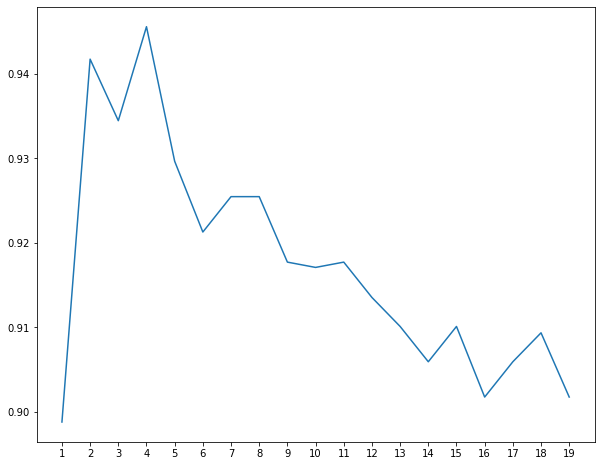

In [157]:
plt.figure(figsize=(10,8))
ax = plt.subplot()
plt.plot(range(1,20), scores)
ax.set_xticks(range(1,20))
plt.show()

### K-Neighbors Classifier (Undersampled)

In [177]:
knn_rus = KNeighborsClassifier(n_neighbors=4)
knn_rus.fit(X_train, np.ravel(y_train))
knn_rus_predict = knn_rus.predict_proba(X_test)[:, 1]
print(average_precision_score(y_test, knn_rus_predict))
knn_prec, knn_recall, knn_threshold = precision_recall_curve(y_test, knn_rus_predict)
print(auc(knn_recall, knn_prec))

0.9757575777314522
0.9842876483180638


### Random Forest Classifier (Undersampler)

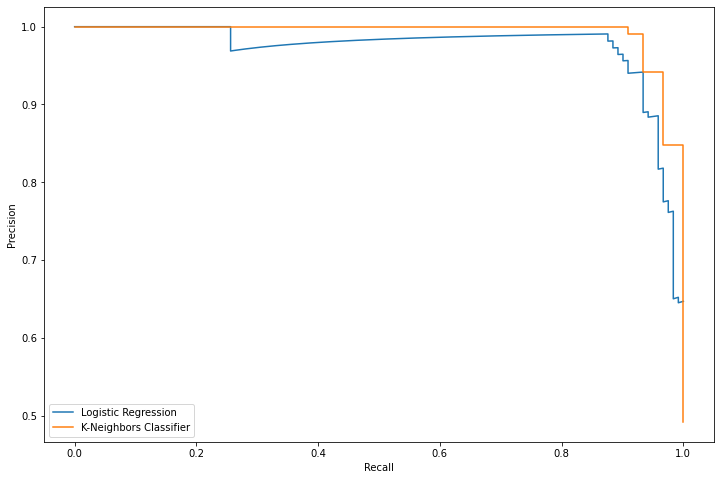

In [182]:
plt.figure(figsize=(12,8))
plt.plot(FP_rate_lr, TP_rate_lr, label='Logistic Regression')
plt.plot(FP_rate_tree, TP_rate_tree, label='Decision Tree')
plt.plot(FP_rate_knn, TP_rate_knn, label='K-Neighbors Classifier')
plt.plot([0,1], ls='--')
plt.plot([0,0], [1,0], c=".7"), plt.plot([1,1], c=".7")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()